## Summary

---

## Imports

In [1]:
import json
import os
import sys
import tempfile
import urllib.request
from datetime import datetime
from pathlib import Path

import dotenv
import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import torch
from elaspic2.plugins.msa import analyze_msa
from kmbio import PDB
from kmtools import structure_tools
from tqdm.auto import tqdm

## Parameters

In [2]:
NOTEBOOK_DIR = Path("40_cagi6_hmbs_submission").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/40_cagi6_hmbs_submission')

In [3]:
src_dir = str(NOTEBOOK_DIR.parents[1].joinpath("src"))
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

import helpers

In [4]:
UNIPROT_ID = "P08397"

UNIPROT_ID

'P08397'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [6]:
version = datetime.now().isoformat(timespec="hours")

version

'2021-10-01T21'

## Download data

In [7]:
def download(url, filename):
    urllib.request.urlretrieve(url, filename)

In [8]:
if not NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", "validation.py").is_file():
    import synapseclient
    import synapseutils

    dotenv.load_dotenv("../.env")
    syn = synapseclient.Synapse()
    syn.login(os.environ["SYNAPSE_USERNAME"], os.environ["SYNAPSE_PASSWORD"])
    _ = synapseutils.syncFromSynapse(syn, "syn25823964", path=NOTEBOOK_DIR)

In [9]:
sequence_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", f"{UNIPROT_ID}.fasta")

if not sequence_file.is_file():
    download(f"https://www.uniprot.org/uniprot/{UNIPROT_ID}.fasta", sequence_file)

In [10]:
structure_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", f"{UNIPROT_ID}.pdb")

if not structure_file.is_file():
    download(
        f"https://alphafold.ebi.ac.uk/files/AF-{UNIPROT_ID}-F1-model_v1.pdb",
        structure_file,
    )

## Load data

In [11]:
def load_sequence(sequence_file):
    with sequence_file.open("rt") as fin:
        data = fin.read()
    chunks = []
    for line in data.split("\n"):
        if line.startswith(">"):
            continue
        chunks.append(line.strip())
    return "".join(chunks)

In [12]:
aaa_dict = {**structure_tools.constants.AAA_DICT, "TER": "*"}


def format_mutation(mutation):
    wt, pos, mut = mutation

    wt = aaa_dict[wt.upper()]
    mut = wt if mut == "=" else aaa_dict[mut.upper()]
    pos = int(pos)

    return f"{wt}{pos}{mut}"

In [13]:
def mutation_matches_sequence(mutation, sequence):
    wt, pos, mut = mutation[0], mutation[1:-1], mutation[-1]
    pos = int(pos)
    return sequence[pos - 1] == wt

In [14]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [15]:
result_template_df = pd.read_csv(
    NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", "HMBS_variant_template.tsv"), sep="\t"
)

display(result_template_df.head(2))
len(result_template_df)

,aa_substitution,score,sd,comments
0,p.Ala112=,*,*,*
1,p.Ala112Arg,*,*,*


6894

In [16]:
result_df = result_template_df.copy()
result_df["mut"] = [
    format_mutation(mut)
    for mut in (
        result_df["aa_substitution"].str.findall("p.([a-zA-Z]+)([1-9]+[0-9]*)([a-zA-Z=]+)").str[0]
    )
]
result_df = result_df[
    ~result_df["mut"].str.contains("*", regex=False)
    & ~(result_df["mut"].str[0] == result_df["mut"].str[-1])
]

display(result_df.head(2))
len(result_df)

,aa_substitution,score,sd,comments,mut
1,p.Ala112Arg,*,*,*,A112R
2,p.Ala112Asn,*,*,*,A112N


6239

In [17]:
sequence = load_sequence(sequence_file)

In [18]:
assert all([mutation_matches_sequence(mut, sequence) for mut in result_df["mut"]])

In [19]:
with structure_file.open("r") as fin:
    structure_blob = fin.read()

assert sequence_matches_structure(sequence, structure_blob)

In [20]:
alignment_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", f"{UNIPROT_ID}.a3m.gz")

if not alignment_file.is_file():
    from elaspic2.plugins.alphafold import mmseqs2

    dotenv.load_dotenv("../.env")
    with mmseqs2.api_gateway(mmseqs2.MMSEQS2_HOST_URL) as gateway:
        alignment = mmseqs2.run_mmseqs2(sequence, gateway=gateway)
        assert alignment[1] == f"{sequence}\n"
        alignment_df = pd.DataFrame({"alignment": alignment})
        pq.write_table(pa.Table.from_pandas(alignment_df, preserve_index=False), alignment_file)

alignment = pq.read_table(alignment_file).to_pandas()["alignment"].values.tolist()

## Load `ELASPIC2` results

In [21]:
el2_results_df = pq.read_table(
    NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_el2", "results-el2.parquet")
).to_pandas(integer_object_nulls=False)

In [22]:
display(el2_results_df.head(2))
print(len(el2_results_df))

,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112Arg,*,*,*,A112R,0.936811,0.809968,2.995820
1,p.Ala112Asn,*,*,*,A112N,0.936790,0.809852,3.083116


6239


## Load Rosetta results

In [23]:
rosetta_result_dir = NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_rosetta", "results")

num_files = 60
dfs = []
for i in range(1, num_files + 1):
    path = rosetta_result_dir.joinpath(f"results-rosetta-{i}-of-60.parquet")
    df = pq.read_table(path).to_pandas(integer_object_nulls=False)
    dfs.append(df)

rosetta_results_df = pd.concat(dfs, ignore_index=True)

In [24]:
display(rosetta_results_df.head(2))
print(len(rosetta_results_df))

,mut,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,...,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change
0,A112R,338.613,115.983,-68.995,166.124,-46.268,289.224,183.036,168.985,150.777,...,-0.029,-8.113333,5.208,1.644,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333
1,A112N,338.613,115.983,-68.995,166.124,-46.268,289.224,183.036,168.985,150.777,...,-0.013,-4.872000,3.027,0.721,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000


6239


## Load AlphaFold results

In [25]:
alphafold_results_df = pq.read_table(
    NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_alphafold", "alphafold-wt-results.parquet")
).to_pandas(integer_object_nulls=False)

In [26]:
proteinsolver_results_df = pq.read_table(
    NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_alphafold", "proteinsolver-results.parquet")
).to_pandas(integer_object_nulls=False)

In [27]:
protbert_results_df = pq.read_table(
    NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_alphafold", "protbert-results.parquet")
).to_pandas(integer_object_nulls=False)

## Run MSA

In [28]:
msa_results_file = NOTEBOOK_DIR.joinpath("msa-results.parquet")

if msa_results_file.is_file():
    msa_results_df = pq.read_table(msa_results_file).to_pandas()
else:
    from elaspic2.plugins.msa import analyze_msa

    msa_sequences = analyze_msa.alignment_to_sequences(alignment)
    assert sequence == msa_sequences[0]
    assert all([len(sequence) == len(seq) for seq in msa_sequences])

    msa_counts_mat = analyze_msa.sequences_to_counts(msa_sequences)
    msa_probas_mat = analyze_msa.counts_to_probas(msa_counts_mat)
    msa_length = len(msa_sequences)
    msa_proba_mean = np.mean(
        [msa_probas_mat[i, analyze_msa.AMINO_ACIDS.index(aa)] for i, aa in enumerate(sequence)]
    )
    msa_conservation_df = analyze_msa.run_convervation_script(msa_sequences)

    msa_results = []
    for mutation in result_df["mut"]:
        msa_result = analyze_msa.featurize_mutation(
            mutation,
            sequence=sequence,
            msa_counts_mat=msa_counts_mat,
            msa_probas_mat=msa_probas_mat,
            msa_conservation_df=msa_conservation_df,
            msa_length=msa_length,
            msa_proba_mean=msa_proba_mean,
        )
        msa_results.append(msa_result)
    msa_results_df = pd.DataFrame(msa_results)
    pq.write_table(pa.Table.from_pandas(msa_results_df, preserve_index=False), msa_results_file)

In [29]:
display(msa_results_df.head(2))
print(len(msa_results_df))

,mut,msa_count_wt,msa_count_mut,msa_count_total,msa_proba_wt,msa_proba_mut,msa_proba_total,msa_length,msa_proba,msa_H,msa_KL
0,A112R,11812.0,23.0,16834.0,-0.355387,-6.554289,-103.243635,19424,-1.351628,1.197971,1.535048
1,A112N,11812.0,9.0,16834.0,-0.355387,-7.429758,-103.243635,19424,-1.351628,1.197971,1.535048


6239


## Run ELASPIC2 + AlphaFold

In [30]:
prediction_df = (
    proteinsolver_results_df
    #
    .merge(protbert_results_df, on=["mut"])
    .merge(rosetta_results_df, on=["mut"])
    .merge(msa_results_df, on=["mut"])
    .merge(alphafold_results_df, on=["mut"])
    .merge(el2_results_df[["mut", "el2_score"]], on=["mut"])
)

prediction_df["aa_wt_onehot"] = (
    prediction_df["mut"].str[0].map(analyze_msa.RESIDUE_ENCODING_WT).apply(list)
)
prediction_df["aa_mut_onehot"] = (
    prediction_df["mut"].str[-1].map(analyze_msa.RESIDUE_ENCODING_MUT).apply(list)
)

for column in list(prediction_df):
    if not column.endswith("_mut"):
        continue

    column_wt = column.removesuffix("_mut") + "_wt"
    if column_wt not in prediction_df:
        print(column_wt)
        continue

    column_change = column.removesuffix("_mut") + "_change"
    prediction_df[column_change] = prediction_df[column_wt] - prediction_df[column]
    del prediction_df[column]

In [31]:
model_infos = [
    ("7f9826be", "optimized"),
    # ("900500fe", "optimized"),
]

for unique_id, model_type in model_infos:
    scalar_features, vector_features = helpers.load_features(NOTEBOOK_DIR.parent, unique_id)
    features_to_exclude = helpers.load_features_to_exclude(
        NOTEBOOK_DIR.parent, unique_id, model_type
    )
    best_parameters = helpers.load_best_parameters(NOTEBOOK_DIR.parent, unique_id, model_type)
    models = helpers.load_best_models(NOTEBOOK_DIR.parent, unique_id, model_type)

    mask = ~prediction_df[scalar_features + vector_features].isnull().any(axis=1)

    X_ref = np.c_[
        prediction_df.loc[mask, scalar_features].values,
        np.hstack([np.vstack(prediction_df.loc[mask, col].values) for col in vector_features]),
    ]

    if features_to_exclude is not None:
        feature_mask = np.ones(X_ref.shape[1], dtype=bool)
        feature_mask[np.array(features_to_exclude, dtype=int)] = False
        X = X_ref[:, feature_mask]
        assert len(features_to_exclude) == X_ref.shape[1] - X.shape[1]
    else:
        X = X_ref

    for model_idx, model in enumerate(models):
        prediction_df.loc[mask, f"pred_{unique_id}_{model_type}_{model_idx}"] = model.predict(X)

    pred_column = f"pred_{unique_id}_{model_type}"
    prediction_df[pred_column] = prediction_df.loc[
        mask, [f"pred_{unique_id}_{model_type}_{model_idx}" for model_idx in range(len(models))]
    ].mean(axis=1)

## Visualize output

In [32]:
for column in ["pred_7f9826be_optimized"]:
    prediction_df[f"{column}_score"] = prediction_df[column]

In [33]:
final_result_df = el2_results_df.merge(rosetta_results_df, on=["mut"], how="left", validate="1:1").merge(
    prediction_df[
        ["mut"]
        + [
            c
            for c in prediction_df
            if c.startswith("pred_") and (c.endswith("_score") or c.endswith("_ratio"))
        ]
    ]
)


assert len(final_result_df) == len(el2_results_df) == len(rosetta_results_df)

In [34]:
display(final_result_df.head(2))
print(len(final_result_df))

,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,pred_7f9826be_optimized_score
0,p.Ala112Arg,*,*,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,-8.113333,5.208,1.644,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,1.0
1,p.Ala112Asn,*,*,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,-4.872000,3.027,0.721,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,1.0


6239


(array([  26.,   96.,  457., 1243., 1377., 1049.,  738.,  551.,  432.,
         270.]),
 array([-0.58611891, -0.42772953, -0.26934014, -0.11095076,  0.04743862,
         0.20582801,  0.36421739,  0.52260678,  0.68099616,  0.83938554,
         0.99777493]),
 <BarContainer object of 10 artists>)

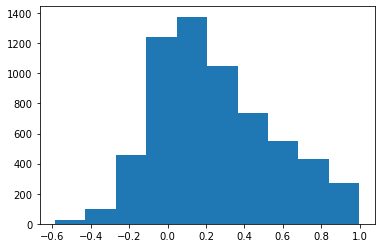

In [35]:
final_result_df["rosetta_score"] = np.tanh(np.clip(final_result_df["rosetta_dg_change"], -51, 51) / 15)

plt.hist(final_result_df["rosetta_score"])

In [36]:
final_result_df[
    [
        "el2_score",
        "proteinsolver_score",
        "protbert_score",
        "rosetta_score",
        "pred_7f9826be_optimized_score",
    ]
].corr()

,el2_score,proteinsolver_score,protbert_score,rosetta_score,pred_7f9826be_optimized_score
el2_score,1.000000,0.583297,0.796337,0.522826,0.790252
proteinsolver_score,0.583297,1.000000,0.390946,0.434050,0.412602
protbert_score,0.796337,0.390946,1.000000,0.315095,0.735610
rosetta_score,0.522826,0.434050,0.315095,1.000000,0.501984
pred_7f9826be_optimized_score,0.790252,0.412602,0.735610,0.501984,1.000000


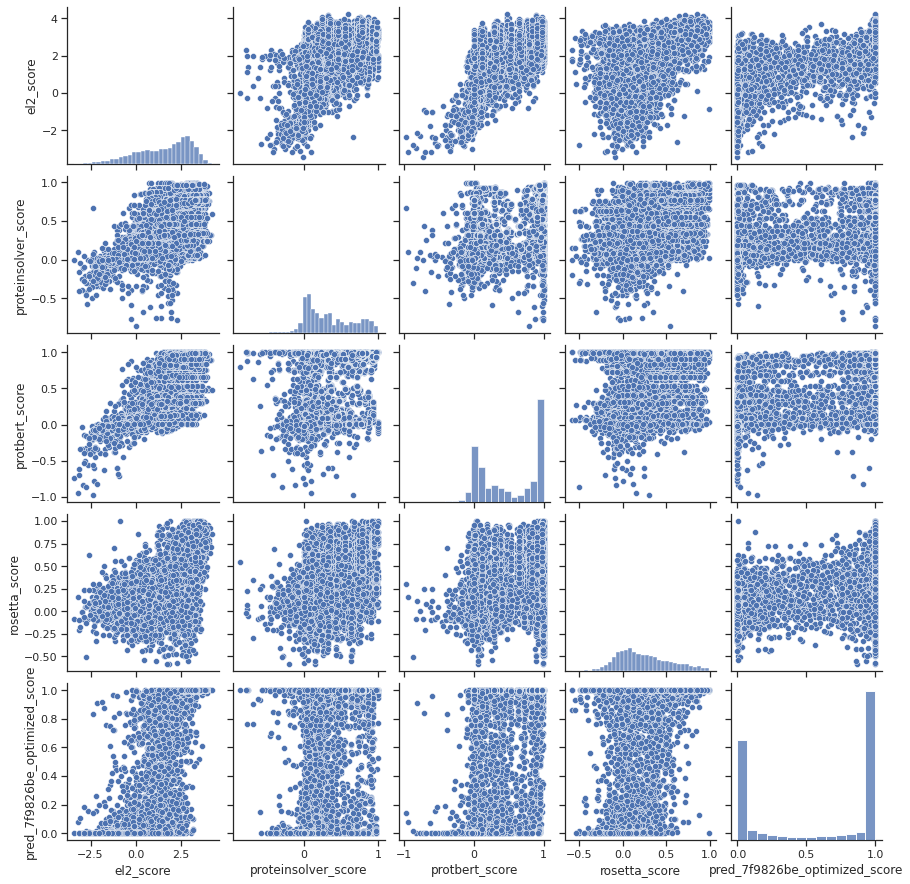

In [37]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    final_result_df[
        [
            "el2_score",
            "proteinsolver_score",
            "protbert_score",
            "rosetta_score",
            "pred_7f9826be_optimized_score",
        ]
    ]
)

## Write results

In [38]:
output_dir = NOTEBOOK_DIR.joinpath("submission")
output_dir.mkdir(exist_ok=True)

output_dir

PosixPath('/home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/40_cagi6_hmbs_submission/submission')

In [39]:
%%file {output_dir}/strokach_desc.md
# Submission for CAGI6—HMBS challenge

## Overview

- `strokach_modelnumber_1.tsv` → Predictions made using ELASPIC2 [1].
- `strokach_modelnumber_2.tsv` → Predictions made using ProteinSolver [2].
- `strokach_modelnumber_3.tsv` → Predictions made using ProtBert [3].
- `strokach_modelnumber_4.tsv` → Predictions made using Rosetta's cartesian_ddg protocol [4].
- `strokach_modelnumber_5.tsv` → Predictions made using ELASPIC2 with AlphaFold [5] features for wildtype protein.

## References

- [1] Strokach et al. (2021). _ELASPIC2 (EL2): Combining Contextualized Language Models and Graph Neural Networks to Predict Effects of Mutations._ https://doi.org/10.1016/j.jmb.2021.166810
- [2] Strokach et al. (2020). _Fast and Flexible Protein Design Using Deep Graph Neural Networks._ https://doi.org/10.1016/j.cels.2020.08.016
- [3] Elnaggar et al. (2020). _ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing._ https://doi.org/10.1101/2020.07.12.199554
- [4] Park et al. (2016). _Simultaneous Optimization of Biomolecular Energy Functions on Features from Small Molecules and Macromolecules._ https://doi.org/10.1021/acs.jctc.6b00819
- [5] Jumper et al. (2021). _Highly accurate protein structure prediction with AlphaFold._ https://doi.org/10.1038/s41586-021-03819-2

Overwriting /home/kimlab5/strokach/workspace/elaspic/elaspic2-cagi6/notebooks/40_cagi6_hmbs_submission/submission/strokach_desc.md


In [40]:
display(result_template_df.head(2))
len(result_template_df)

,aa_substitution,score,sd,comments
0,p.Ala112=,*,*,*
1,p.Ala112Arg,*,*,*


6894

In [41]:
result_dfs = {}
for i, metric in enumerate(
    ["el2", "proteinsolver", "protbert", "rosetta", "pred_7f9826be_optimized"]
):
    result_dfs[metric] = result_template_df[["aa_substitution"]].merge(
        final_result_df, on=["aa_substitution"], how="left"
    )
    assert len(result_dfs[metric]) == len(result_template_df)

    result_dfs[metric]["score"] = (
        1
        - result_dfs[metric][f"{metric}_score"].values
        / result_dfs[metric][f"{metric}_score"].abs().max()
    )
    result_dfs[metric]["sd"] = 1.0
    result_dfs[metric]["comments"] = "*"

    mask_nochange = result_dfs[metric]["aa_substitution"].str.endswith("=")
    result_dfs[metric].loc[mask_nochange, "score"] = 1.0

    mask_ter = result_dfs[metric]["aa_substitution"].str.contains("Ter", regex=False)
    result_dfs[metric].loc[mask_ter, "score"] = 0.0
    result_dfs[metric].loc[mask_ter, "comments"] = "Wild guess"

    print(metric)
    display(result_dfs[metric].head())

    output_file = output_dir.joinpath(f"strokach_modelnumber_{i + 1}.tsv")
    result_dfs[metric][result_template_df.columns].to_csv(output_file, sep="\t", index=False)
    assert len(result_dfs[metric]) == len(result_template_df)

    !python {NOTEBOOK_DIR.parent}/30_cagi6_hmbs/validation.py {output_file}

el2


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,pred_7f9826be_optimized_score,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.294013,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,1.000000,0.963693
2,p.Ala112Asn,0.273442,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,1.000000,0.598838
3,p.Ala112Asp,0.218195,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,1.000000,0.766148
4,p.Ala112Cys,0.704368,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.946282,0.400239


The file's format is valid! You are good to submit now!
proteinsolver


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,pred_7f9826be_optimized_score,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.183368,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,1.000000,0.963693
2,p.Ala112Asn,0.183485,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,1.000000,0.598838
3,p.Ala112Asp,0.183284,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,1.000000,0.766148
4,p.Ala112Cys,0.198573,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.946282,0.400239


The file's format is valid! You are good to submit now!
protbert


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,pred_7f9826be_optimized_score,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.062969,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,1.000000,0.963693
2,p.Ala112Asn,0.062990,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,1.000000,0.598838
3,p.Ala112Asp,0.063013,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,1.000000,0.766148
4,p.Ala112Cys,0.088316,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.946282,0.400239


The file's format is valid! You are good to submit now!
rosetta


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,pred_7f9826be_optimized_score,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.034158,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,1.000000,0.963693
2,p.Ala112Asn,0.399827,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,1.000000,0.598838
3,p.Ala112Asp,0.232144,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,1.000000,0.766148
4,p.Ala112Cys,0.598869,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.946282,0.400239


The file's format is valid! You are good to submit now!
pred_7f9826be_optimized


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,pred_7f9826be_optimized_score,rosetta_score
0,p.Ala112=,1.000000e+00,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,7.249437e-09,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,1.000000,0.963693
2,p.Ala112Asn,7.213228e-08,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,1.000000,0.598838
3,p.Ala112Asp,4.970205e-08,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,1.000000,0.766148
4,p.Ala112Cys,5.371807e-02,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.946282,0.400239


The file's format is valid! You are good to submit now!


el2 0.0
proteinsolver 0.0
protbert 0.0
rosetta 0.0
pred_7f9826be_optimized 0.0


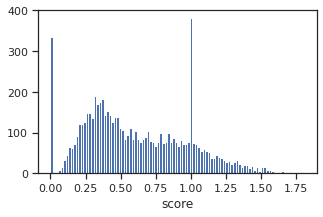

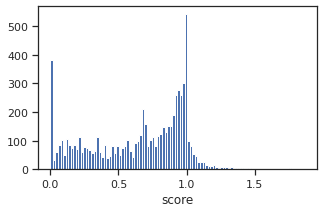

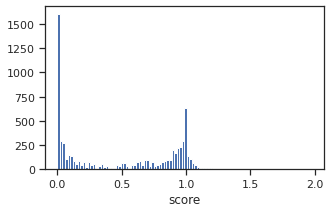

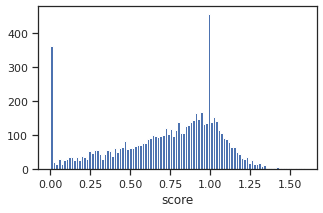

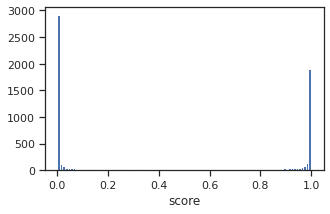

In [42]:
for metric, df in result_dfs.items():
    print(metric, df["score"].min())

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(df["score"], bins=100)
    ax.set_xlabel("score")